# Gaussianization Flows (Details)

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse


KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext lab_black
# %load_ext autoreload
# %autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [3]:
from rbig_jax.data import NoisySineDataset, MoonsDataset
from sklearn.preprocessing import StandardScaler

# %%wandb
# get data
seed = 123
n_samples = 1_000_000
n_features = 2
noise = 0.1
n_train = 5_000
n_valid = 1_000

ds = NoisySineDataset(n_samples=n_samples, noise=noise, seed=seed)
# def load_data(n_samples, seed):
#     dataset = Dataset2D(n_samples=n_samples, seed=seed)

#     data = dataset.load_s_curve()
#     return data


data = ds[:n_train]
X_plot = ds[n_train:]
data = StandardScaler().fit_transform(data)

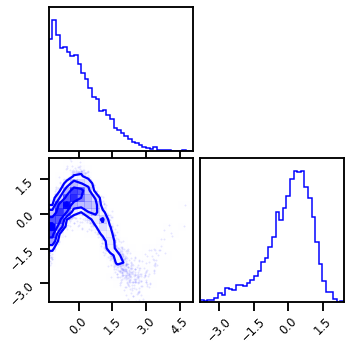

In [4]:
# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

In [5]:
X = jnp.array(data, dtype=np.float32)

## DataLoader

In [6]:
from rbig_jax.data import GenericDataset, collate_fn
import torch.multiprocessing as multiprocessing
from torch.utils.data import DataLoader

# multiprocessing.set_start_method("spawn")

# initialize dataset
ds_train = GenericDataset(np.array(data))
ds_valid = GenericDataset(np.array(X_plot[n_train : n_train + n_valid]))

# initialize dataloader
batch_size = 256
shuffle = True

train_dl = DataLoader(
    ds_train, batch_size=batch_size, shuffle=shuffle, collate_fn=None, num_workers=0
)
valid_dl = DataLoader(
    ds_valid, batch_size=batch_size, shuffle=False, collate_fn=None, num_workers=0
)

## Model

In [7]:
from rbig_jax.models.gaussflow import init_default_gf_model

In [8]:
n_blocks = 5
n_reflections = 10
init_mixcdf = "random"
init_rotation = "pca"
plot_layers = False
plot_blocks = False
X_init = X

# init model
gf_model = init_default_gf_model(
    shape=X.shape[1:],
    X=X_init,
    n_blocks=n_blocks,
    init_mixcdf=init_mixcdf,
    init_rotation=init_rotation,
    n_reflections=n_reflections,
    plot_layers=plot_layers,
)

Initializing - Block: 5 | Layer 14: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


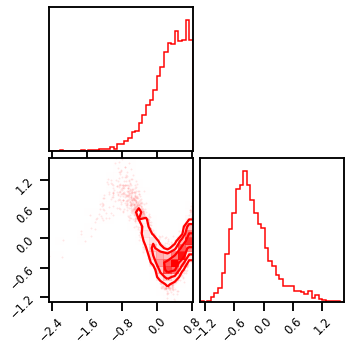

In [9]:
X_g = gf_model.forward(X)

# plot data
fig = corner.corner(X_g, color="red", hist_bin_factor=2)

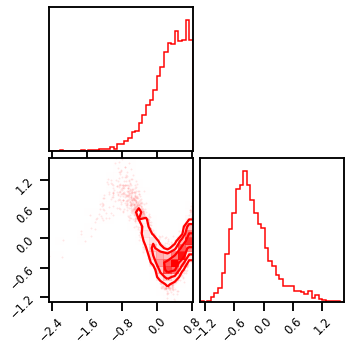

In [10]:
X_g = gf_model.forward(X)

# plot data
fig = corner.corner(X_g, color="red", hist_bin_factor=2)

#### Layer I - Mixture CDF

In [11]:
# parameters
n_components = 20
n_features = 2
shape = (2,)
key = jax.random.PRNGKey(123)
init_method = "gmm"

init_mixcdf_f = InitMixtureLogisticCDF(
    n_components=n_components, init_method=init_method
)
# init_mixcdf_f = InitMixtureGaussianCDF(
#     n_components=n_components, init_method=init_method
# )

#### Layer II - Logit/Inverse CDF Transform

In [12]:
# Logit Transformation
init_logit_f = InitLogitTransform()
# init_logit_f = InitInverseGaussCDF()

#### Layer III - HouseHolder Transformation

In [13]:
# Householder Transformation
n_reflections = 10
method = "pca"

# initialize init function
init_hh_f = InitHouseHolder(n_reflections=n_reflections, method=method)

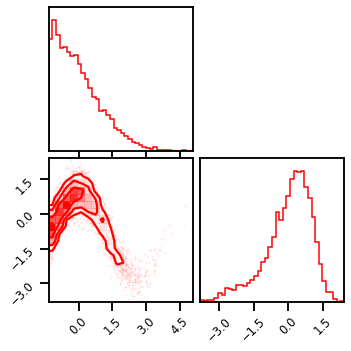

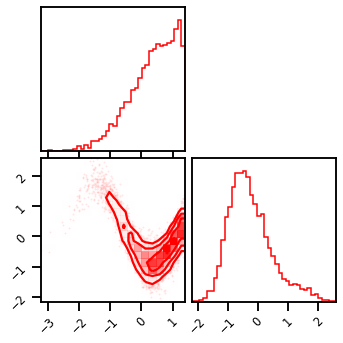

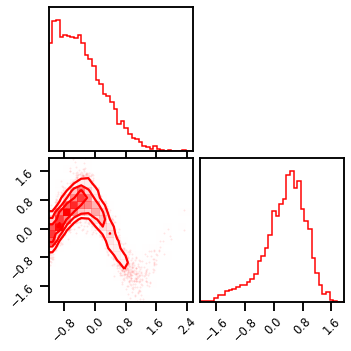

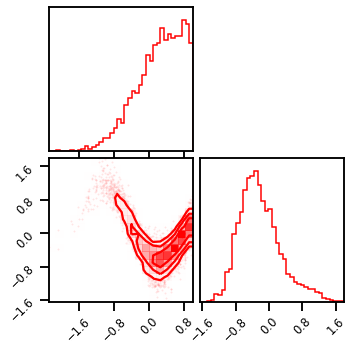

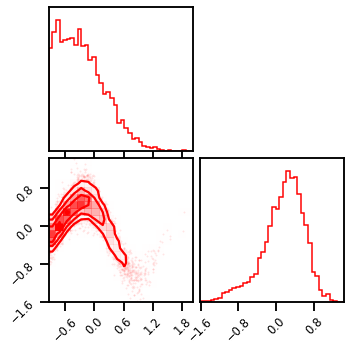

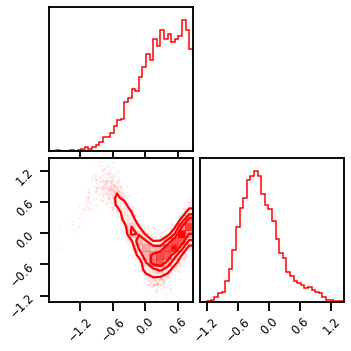

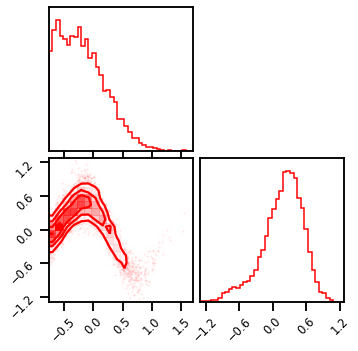

In [14]:
# Layer Params
n_layers = 6
bijectors = []

rng, *layer_rngs = jax.random.split(KEY, num=n_layers + 1)

X_g = X.copy()

# Plotting
plot_layers = True
plot_intermediates = False

if plot_layers:
    fig = corner.corner(X_g, color="red", hist_bin_factor=2)

for irng in layer_rngs:

    # ======================
    # MIXTURECDF
    # ======================
    # create keys for all inits
    irng, icdf_rng = jax.random.split(irng, 2)

    # intialize bijector and transformation
    X_g, layer = init_mixcdf_f.bijector_and_transform(
        inputs=X_g, rng=icdf_rng, n_features=n_features
    )

    # plot data
    if plot_layers and plot_intermediates:
        fig = corner.corner(X_g, color="red", hist_bin_factor=2)

    # add bijector to list
    bijectors.append(layer)

    # ======================
    # LOGIT
    # ======================

    # intialize bijector and transformation
    X_g, layer = init_logit_f.bijector_and_transform(inputs=X_g)

    bijectors.append(layer)

    # plot data
    if plot_layers and plot_intermediates:
        fig = corner.corner(X_g, color="red", hist_bin_factor=2)

    # ======================
    # HOUSEHOLDER
    # ======================

    # create keys for all inits
    irng, hh_rng = jax.random.split(irng, 2)

    # intialize bijector and transformation
    X_g, layer = init_hh_f.bijector_and_transform(
        inputs=X_g, rng=hh_rng, n_features=n_features
    )

    bijectors.append(layer)

    # plot data
    if plot_layers:
        fig = corner.corner(X_g, color="red", hist_bin_factor=2)

In [15]:
from rbig_jax.models import GaussianizationFlow
from distrax._src.distributions.normal import Normal

# create base dist
base_dist = Normal(jnp.zeros((n_features,)), jnp.ones((n_features,)))

# create flow model
gf_model = GaussianizationFlow(base_dist=base_dist, bijectors=bijectors)

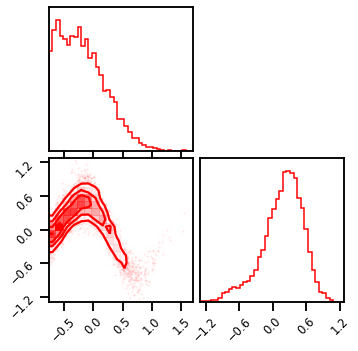

In [16]:
X_g = gf_model.forward(X)

# plot data
fig = corner.corner(X_g, color="red", hist_bin_factor=2)

#### Training

In [17]:
from jax.experimental import optimizers
from rbig_jax.training.parametric import init_train_op, init_gf_train_op, train_model


# lr = 0.05
lr = 0.005
optimizer = optimizers.adam(step_size=lr)
jitted = True
# epochs = 150
epochs = 200

# train model
final_bijector, losses = train_model(
    gf_model,
    train_dl=train_dl,
    valid_dl=None,
    epochs=epochs,
    optimizer=optimizer,
    jitted=jitted,
)

100%|██████████| 200/200 [01:08<00:00,  2.90it/s, Train Loss=1.8671, Valid Loss=0.0000]


### Results

#### Losses

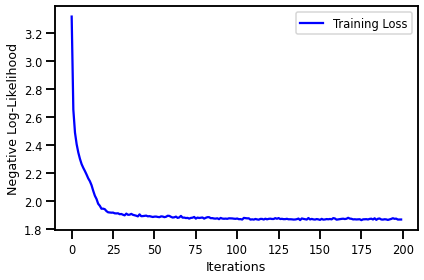

In [18]:
fig, ax = plt.subplots()
ax.plot(losses["train"], label="Training Loss", color="blue")
# ax.plot(losses["valid"], label="Validation Loss", color="orange")
ax.set(xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.legend()
plt.tight_layout()
plt.show()

#### Latent Space

CPU times: user 755 ms, sys: 41.2 ms, total: 796 ms
Wall time: 678 ms


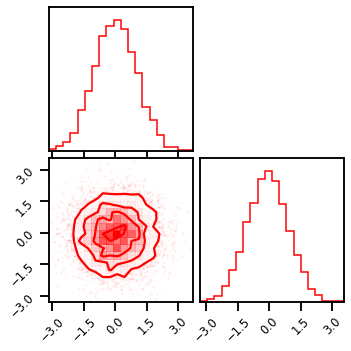

In [19]:
%%time
X_trans = final_bijector.forward(data)

fig = corner.corner(X_trans, color="Red")

#### Inverse Transform

CPU times: user 53.9 s, sys: 3.17 s, total: 57 s
Wall time: 20.7 s


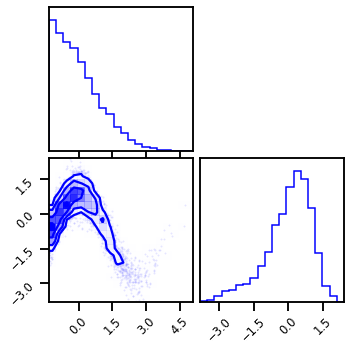

In [20]:
%%time

X_approx = final_bijector.inverse(X_trans)

fig = corner.corner(X_approx, color="Blue")

### Log Probability

In [21]:
%%time

from rbig_jax.data import generate_2d_grid

# general grid points
xyinput = generate_2d_grid(X, 500, buffer=0.2)

# calculate log probability
X_log_prob = final_bijector.score_samples(xyinput)

CPU times: user 7.35 s, sys: 2.42 s, total: 9.76 s
Wall time: 4.01 s


#### Plot: Original Density

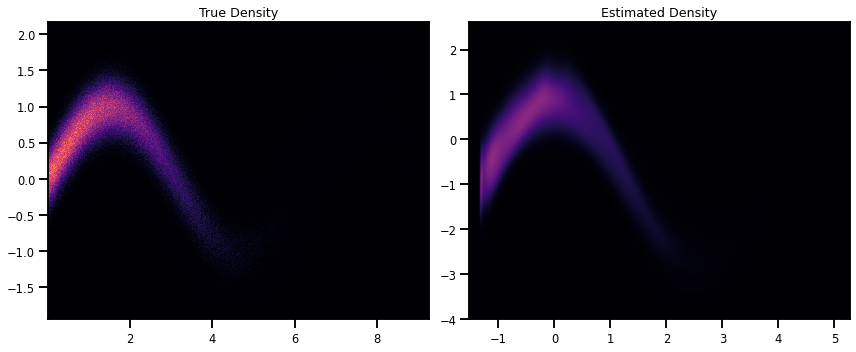

In [22]:
# # Original Density
# n_samples = 1_000_000
# n_features = 2
# X_plot = get_classic(n_samples, seed=123)
# X_plot = scaler.transform(X_plot)

# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)

h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
# plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

### Sampling

In [23]:
%%time
n_gen_samples = 100_000
X_samples = final_bijector.sample(seed=123, n_samples=n_gen_samples)

CPU times: user 17min 12s, sys: 3.97 s, total: 17min 16s
Wall time: 3min 23s


In [24]:
# %%time
# # generate samples in the latent domain
# n_gen_samples = 10_000

# X_g_samples = Normal(0.0, 1.0).sample(seed=123, sample_shape=(n_gen_samples, 2))

# X_samples = final_bijector.inverse(X_g_samples)

# X_samples = np.array(gf_model.inverse(X_g_samples.block_until_ready()))

# # inverse transformation
# f = jax.jit(gf_model.inverse)
# X_samples = np.array(f(X_g_samples))

# # This way works too! But slower
# # generate samples in the latent domain
# n_gen_samples = 10_000

# # # inverse transformation
# X_samples = final_bijector.sample(seed=123, n_samples=n_gen_samples)

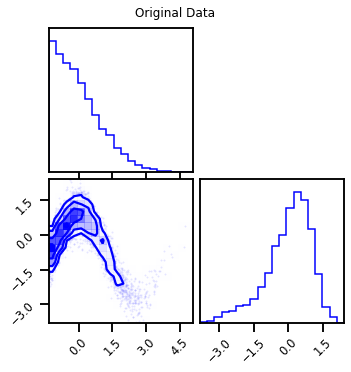

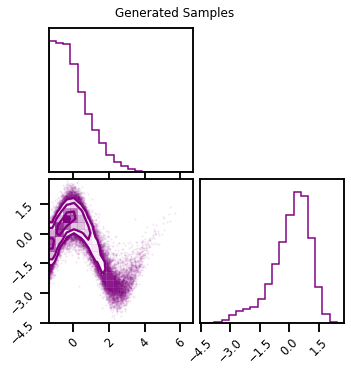

In [25]:
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Each Layer

#### Original

In [26]:
10 * 3 * 32 * 32

30720

In [27]:
10 * (32 // 2) * (32 // 2)

2560

In [28]:
3 * 2 * 2

12

In [29]:
1 * 16 * 16 * 3

768

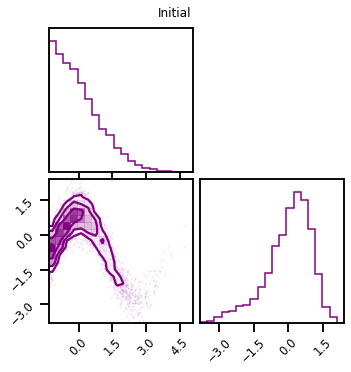

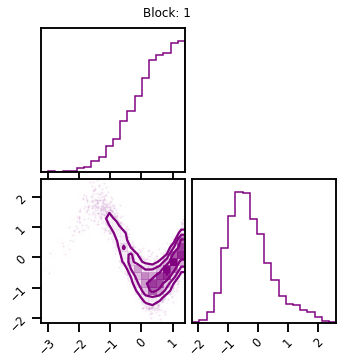

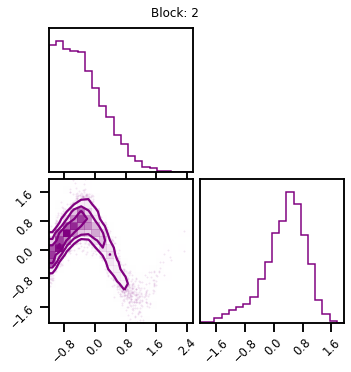

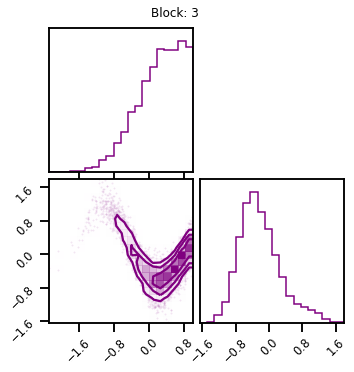

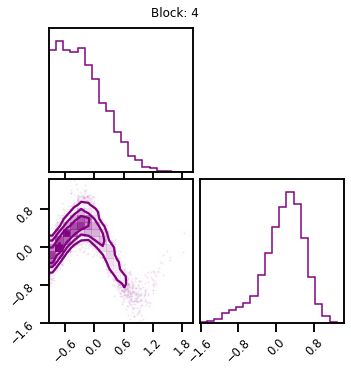

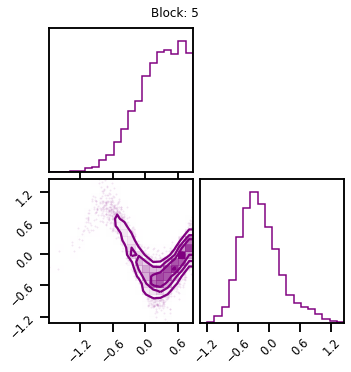

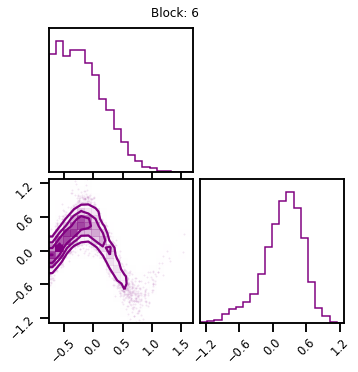

In [30]:
X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(gf_model.bijectors):

    X_g = ibijector.forward(X_g)

    if (ilayer + 1) % 3 == 0:
        fig = corner.corner(X_g, color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()

#### Trained Model

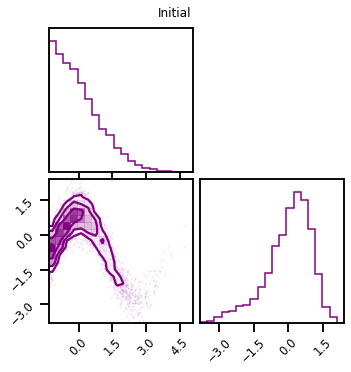

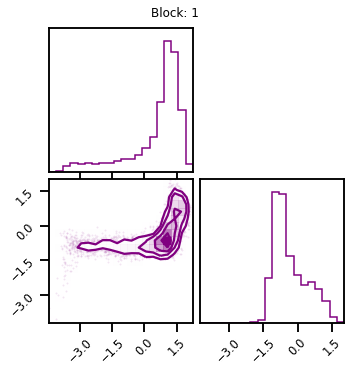

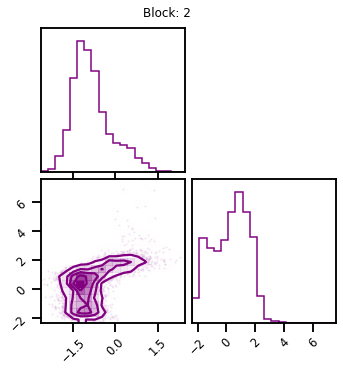

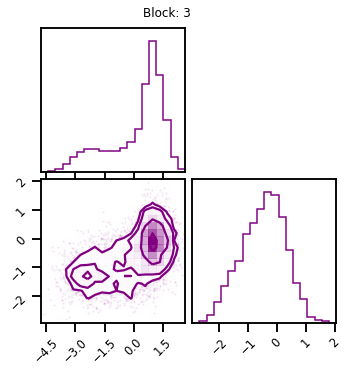

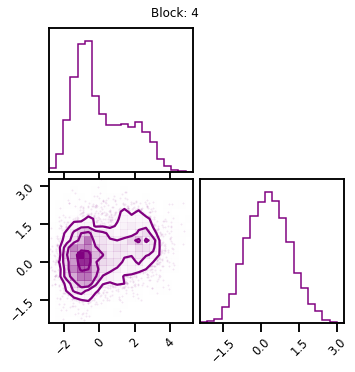

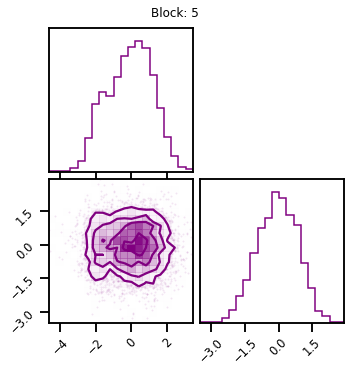

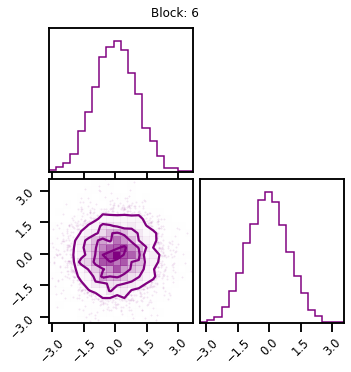

In [31]:
X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(final_bijector.bijectors):

    X_g = ibijector.forward(X_g)

    if (ilayer + 1) % 3 == 0:
        fig = corner.corner(X_g, color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()

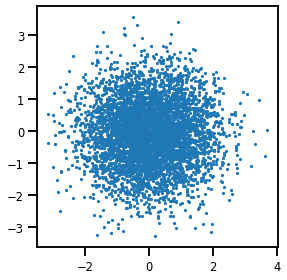

In [32]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=3)
ax.set_aspect("equal", "box")
plt.tight_layout()

## Saving/Loading Model

In [33]:
import pickle

#### Save Model

In [34]:
with open("rbig_model.pickle", "wb") as f:
    pickle.dump(final_bijector, f)

#### Load Model

In [35]:
with open("rbig_model.pickle", "rb") as f:
    rbig_model_ = pickle.load(f)